只使用原始特征

d:\CS\ananconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


训练数值特征张量形状:  torch.Size([15052, 3])
验证数值特征张量形状:  torch.Size([3768, 3])
测试数值特征张量形状:  torch.Size([3174, 3])
合并后的训练特征张量形状:  torch.Size([15052, 399])
合并后的验证特征张量形状:  torch.Size([3768, 399])
合并后的测试特征张量形状:  torch.Size([3174, 399])
Epoch 0: Loss: 4446970.5, MSE: 4446970.5, MAE: 96.11504364013672, Valid MSE: 14087.3662109375, Valid MAE: 78.81539916992188


C:\Users\26384\AppData\Local\Temp\ipykernel_21760\2639763848.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['手术编号'] = range(len(train_data))
C:\Users\26384\AppData\Local\Temp\ipykernel_21760\2639763848.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['手术编号'] = range(len(valid_data))
C:\Users\26384\AppData\Local\Temp\ipykernel_21760\2639763848.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Epoch 1: Loss: 4446724.0, MSE: 4446724.0, MAE: 94.9207992553711, Valid MSE: 13902.9052734375, Valid MAE: 77.68104553222656
Epoch 2: Loss: 4446480.0, MSE: 4446480.0, MAE: 93.7466049194336, Valid MSE: 13726.8291015625, Valid MAE: 76.58547973632812
Epoch 3: Loss: 4446246.5, MSE: 4446246.5, MAE: 92.62149047851562, Valid MSE: 13529.072265625, Valid MAE: 75.3271484375
Epoch 4: Loss: 4445989.5, MSE: 4445989.5, MAE: 91.35218048095703, Valid MSE: 13309.912109375, Valid MAE: 73.90535736083984
Epoch 5: Loss: 4445704.0, MSE: 4445704.0, MAE: 89.9206771850586, Valid MSE: 13063.1826171875, Valid MAE: 72.26626586914062
Epoch 6: Loss: 4445385.5, MSE: 4445385.5, MAE: 88.28801727294922, Valid MSE: 12771.9765625, Valid MAE: 70.29410552978516
Epoch 7: Loss: 4445013.0, MSE: 4445013.0, MAE: 86.35601806640625, Valid MSE: 12425.9541015625, Valid MAE: 67.94095611572266
Epoch 8: Loss: 4444570.5, MSE: 4444570.5, MAE: 84.03707885742188, Valid MSE: 12022.6962890625, Valid MAE: 65.25189971923828
Epoch 9: Loss: 44440

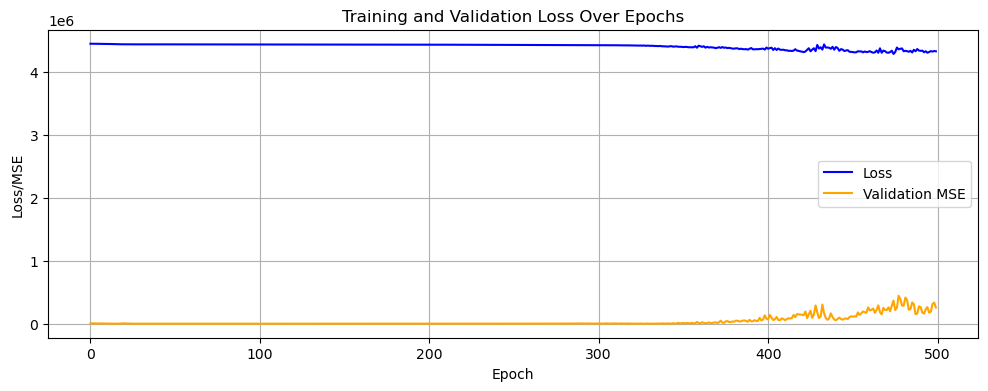

In [ ]:
import pandas as pd
import torch
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader

# deal_data_encoded.csv已经包含之前的one-hot编码和其他特征
deal_data_encoded = pd.read_csv('data_del_en.csv')

# 根据 'InRoom' 标签进行排序
deal_data_encoded = deal_data_encoded.sort_values(by='InRoom')

# # 计算每位医生的手术次数
# doctor_surgery_count_by_type = deal_data_encoded.groupby(['工号']).size().reset_index(name='手术次数')

# # 将手术次数合并到原始数据中
# deal_data_encoded = pd.merge(deal_data_encoded, doctor_surgery_count_by_type, on='工号', how='left')

# 确保 'InRoom' 列为 datetime 类型
deal_data_encoded['InRoom'] = pd.to_datetime(deal_data_encoded['InRoom'], errors='coerce')

# 现在根据 'InRoom' 标签划分训练集、验证集和测试集
train_data = deal_data_encoded[deal_data_encoded['InRoom'].dt.month.isin([1, 2, 3, 4, 5, 6])]  # 1-6月作为训练集
valid_data = deal_data_encoded[deal_data_encoded['InRoom'].dt.month == 7]  # 7月作为验证集
test_data = deal_data_encoded[deal_data_encoded['InRoom'].dt.month == 8]  # 8月作为测试集

# 选择数值特征列：年龄_数值、性别编码、手术等级
train_numerical_features = train_data[['年龄_数值', '性别编码', '手术等级']].values
valid_numerical_features = valid_data[['年龄_数值', '性别编码', '手术等级']].values
test_numerical_features = test_data[['年龄_数值', '性别编码', '手术等级']].values

# 将这些数值特征转换为 PyTorch 张量
train_numerical_features_tensor = torch.tensor(train_numerical_features, dtype=torch.float)
valid_numerical_features_tensor = torch.tensor(valid_numerical_features, dtype=torch.float)
test_numerical_features_tensor = torch.tensor(test_numerical_features, dtype=torch.float)

print("训练数值特征张量形状: ", train_numerical_features_tensor.shape)
print("验证数值特征张量形状: ", valid_numerical_features_tensor.shape)
print("测试数值特征张量形状: ", test_numerical_features_tensor.shape)

# 合并数值特征与 one-hot 编码特征

# 比如one-hot编码后的列以 '工号_', '类目_', '亚目_', '细目_', '操作_'开头
train_one_hot_features = train_data.filter(regex='^(工号_|类目_|亚目_|细目_|操作_)').values
valid_one_hot_features = valid_data.filter(regex='^(工号_|类目_|亚目_|细目_|操作_)').values
test_one_hot_features = test_data.filter(regex='^(工号_|类目_|亚目_|细目_|操作_)').values

# 将这些 one-hot 特征转换为 PyTorch 张量
train_one_hot_features_tensor = torch.tensor(train_one_hot_features, dtype=torch.float)
valid_one_hot_features_tensor = torch.tensor(valid_one_hot_features, dtype=torch.float)
test_one_hot_features_tensor = torch.tensor(test_one_hot_features, dtype=torch.float)

# 将数值特征与one-hot编码特征按列拼接
train_combined_features_tensor = torch.cat([train_one_hot_features_tensor, train_numerical_features_tensor], dim=1)
valid_combined_features_tensor = torch.cat([valid_one_hot_features_tensor, valid_numerical_features_tensor], dim=1)
test_combined_features_tensor = torch.cat([test_one_hot_features_tensor, test_numerical_features_tensor], dim=1)

print("合并后的训练特征张量形状: ", train_combined_features_tensor.shape)
print("合并后的验证特征张量形状: ", valid_combined_features_tensor.shape)
print("合并后的测试特征张量形状: ", test_combined_features_tensor.shape)

# 添加手术编号
train_data['手术编号'] = range(len(train_data))
valid_data['手术编号'] = range(len(valid_data))
test_data['手术编号'] = range(len(test_data))

# 确保 '工号' 和 '手术编号' 列都存在后，再生成 edge_index
train_doctor_ids = train_data['工号'].astype('category').cat.codes.values
train_surgery_ids = train_data['手术编号'].values

valid_doctor_ids = valid_data['工号'].astype('category').cat.codes.values
valid_surgery_ids = valid_data['手术编号'].values

test_doctor_ids = test_data['工号'].astype('category').cat.codes.values
test_surgery_ids = test_data['手术编号'].values

# 创建边索引
train_edge_index = torch.tensor([train_doctor_ids, train_surgery_ids], dtype=torch.long)
valid_edge_index = torch.tensor([valid_doctor_ids, valid_surgery_ids], dtype=torch.long)
test_edge_index = torch.tensor([test_doctor_ids, test_surgery_ids], dtype=torch.long)

# 构建 HeteroData 数据并添加边
train_data_hg = HeteroData()
train_data_hg['doctor', 'performs', 'surgery'].edge_index = train_edge_index

valid_data_hg = HeteroData()
valid_data_hg['doctor', 'performs', 'surgery'].edge_index = valid_edge_index

test_data_hg = HeteroData()
test_data_hg['doctor', 'performs', 'surgery'].edge_index = test_edge_index

# # 确保所有列为数值型，移除非数值列 
# train_doctor_features = train_data[['工号']].apply(pd.to_numeric, errors='coerce').fillna(0)
# valid_doctor_features = valid_data[['工号']].apply(pd.to_numeric, errors='coerce').fillna(0)
# test_doctor_features = test_data[['工号']].apply(pd.to_numeric, errors='coerce').fillna(0)

# 使用 One-Hot 编码的工号作为医生特征
train_doctor_features = train_data.filter(regex='^工号_').apply(pd.to_numeric, errors='coerce').fillna(0)
valid_doctor_features = valid_data.filter(regex='^工号_').apply(pd.to_numeric, errors='coerce').fillna(0)
test_doctor_features = test_data.filter(regex='^工号_').apply(pd.to_numeric, errors='coerce').fillna(0)

# 选择手术相关的基本特征列
surgery_basic_features = ['年龄_数值', '性别编码', '手术等级']

# 筛选one-hot编码的ICD9相关特征列，前缀以'类目_'、'亚目_'、'细目_'和'操作_'开头
ICD9_one_hot_features = train_data.filter(regex='^(类目_|亚目_|细目_|操作_)')

# 确保从每个数据集中选取手术相关特征
train_surgery_features = pd.concat([train_data[surgery_basic_features], ICD9_one_hot_features], axis=1)
valid_surgery_features = pd.concat([valid_data[surgery_basic_features], valid_data.filter(regex='^(类目_|亚目_|细目_|操作_)')], axis=1)
test_surgery_features = pd.concat([test_data[surgery_basic_features], test_data.filter(regex='^(类目_|亚目_|细目_|操作_)')], axis=1)

# 确保所有列为数值型，如果有非数值列则移除或转换
train_surgery_features = train_surgery_features.apply(pd.to_numeric, errors='coerce').fillna(0)
valid_surgery_features = valid_surgery_features.apply(pd.to_numeric, errors='coerce').fillna(0)
test_surgery_features = test_surgery_features.apply(pd.to_numeric, errors='coerce').fillna(0)

# 再次检查非数值列，移除包含非数值数据的列
train_surgery_features = train_surgery_features.select_dtypes(include=[np.number])
valid_surgery_features = valid_surgery_features.select_dtypes(include=[np.number])
test_surgery_features = test_surgery_features.select_dtypes(include=[np.number])

# 创建 HeteroData 对象
train_data_hg['doctor'].x = torch.tensor(train_doctor_features.values, dtype=torch.float)
valid_data_hg['doctor'].x = torch.tensor(valid_doctor_features.values, dtype=torch.float)
test_data_hg['doctor'].x = torch.tensor(test_doctor_features.values, dtype=torch.float)

# 添加手术节点
train_data_hg['surgery'].x = torch.tensor(train_surgery_features.values, dtype=torch.float)
valid_data_hg['surgery'].x = torch.tensor(valid_surgery_features.values, dtype=torch.float)
test_data_hg['surgery'].x = torch.tensor(test_surgery_features.values, dtype=torch.float)

# 定义隐层和输出层的维度
hidden_channels = 64  # 隐层特征数，可调节
target_channels = 2  # 输出特征数，通常设为目标标签的维度

class GNNModel(torch.nn.Module):
    def __init__(self, doctor_feature_dim, surgery_feature_dim, hidden_channels, target_channels):
        super(GNNModel, self).__init__()
        self.conv1 = SAGEConv(doctor_feature_dim, hidden_channels)
        self.linear = torch.nn.Linear(surgery_feature_dim, hidden_channels)

        # 修改卷积层和线性层
        self.conv2 = SAGEConv(hidden_channels * 2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)

        self.conv4 = SAGEConv(hidden_channels * 2, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        self.conv6 = SAGEConv(hidden_channels, target_channels)

        self.mlp1 = torch.nn.Linear(hidden_channels + target_channels, hidden_channels)
        self.mlp2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.mlp3 = torch.nn.Linear(hidden_channels, target_channels)

    def forward(self, data):
        doctor_x = data['doctor'].x
        surgery_x = data['surgery'].x

        x = self.conv1(doctor_x, data['doctor', 'performs', 'surgery'].edge_index).relu()
        surgery_x_transformed = self.linear(surgery_x)

        x = torch.cat([x, surgery_x_transformed], dim=1)
        
        x = self.conv2(x, data['doctor', 'performs', 'surgery'].edge_index).relu()
        x = self.conv3(x, data['doctor', 'performs', 'surgery'].edge_index).relu()

        # 继续后续处理
        x = torch.cat([x, surgery_x_transformed], dim=1)

        x = self.conv4(x, data['doctor', 'performs', 'surgery'].edge_index).relu()
        x = self.conv5(x, data['doctor', 'performs', 'surgery'].edge_index).relu()
        x = self.conv6(x, data['doctor', 'performs', 'surgery'].edge_index)

        x = torch.cat([x, surgery_x_transformed], dim=1)
        x = self.mlp1(x).relu()
        x = self.mlp2(x).relu()
        x = self.mlp3(x)

        return x

# 实例化模型时，确保维度正确
doctor_features_shape = train_doctor_features.shape[1]  # 应该是 1
surgery_features_shape = train_surgery_features.shape[1]  # 依据修改后的手术特征维度
model = GNNModel(doctor_features_shape, surgery_features_shape, hidden_channels, target_channels)

learning_rate = 1e-3
num_epochs = 500  # 根据需要设置
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()  # 均方误差损失函数，用于回归任务

# 假设操作时长和台次时长在原始数据中
train_target = torch.tensor(train_data[['操作时长', '台次时长']].values, dtype=torch.float)
valid_target = torch.tensor(valid_data[['操作时长', '台次时长']].values, dtype=torch.float)
test_target = torch.tensor(test_data[['操作时长', '台次时长']].values, dtype=torch.float)

# 将训练数据装入 DataLoader
batch_size = 32  # 根据可用内存调整
train_data_loader = DataLoader([train_data_hg], batch_size=batch_size, shuffle=True)  # 用训练集创建 DataLoader

# 存储指标
losses = []
maes = []
mses = []
valid_mses = []
valid_maes = []

# 训练过程
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_data in train_data_loader:
        optimizer.zero_grad()

        out = model(batch_data[0])
        
        # 更新目标标签的索引
        target_indices = train_target[:out.size(0)]
        
        loss = criterion(out, target_indices)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # 计算 MAE 和 MSE
    with torch.no_grad():
        mse = torch.mean((out - train_target[:out.size(0)]) ** 2)
        mae = torch.mean(torch.abs(out - train_target[:out.size(0)]))

    # 存储损失和指标
    losses.append(epoch_loss / len(train_data_loader))
    mses.append(mse.item())
    maes.append(mae.item())

    # 验证集评估
    model.eval()
    with torch.no_grad():
        valid_out = model(valid_data_hg)
        valid_mse = torch.mean((valid_out - valid_target) ** 2)
        valid_mae = torch.mean(torch.abs(valid_out - valid_target))
        valid_mses.append(valid_mse.item())
        valid_maes.append(valid_mae.item())

    print(f'Epoch {epoch}: Loss: {epoch_loss / len(train_data_loader)}, MSE: {mse.item()}, MAE: {mae.item()}, Valid MSE: {valid_mse.item()}, Valid MAE: {valid_mae.item()}')

# 训练结束后评估测试集
model.eval()
with torch.no_grad():
    test_out = model(test_data_hg)
    test_mse = torch.mean((test_out - test_target) ** 2)
    test_mae = torch.mean(torch.abs(test_out - test_target))

print(f'Test MSE: {test_mse.item()}, Test MAE: {test_mae.item()}')

# 绘制 Loss 图
plt.figure(figsize=(12, 4))
plt.plot(losses, label='Loss', color='blue')
plt.plot(valid_mses, label='Validation MSE', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss/MSE')
plt.legend()
plt.grid()
plt.show()

加入手术次数和平均操作时长

训练数值特征张量形状:  torch.Size([15052, 3])
验证数值特征张量形状:  torch.Size([3768, 3])
测试数值特征张量形状:  torch.Size([3174, 3])
合并后的训练特征张量形状:  torch.Size([15052, 399])
合并后的验证特征张量形状:  torch.Size([3768, 399])
合并后的测试特征张量形状:  torch.Size([3174, 399])
Epoch 0: Loss: 4446716.5, MSE: 4446716.5, MAE: 94.34136199951172, Valid MSE: 13887.638671875, Valid MAE: 77.3833236694336


C:\Users\26384\AppData\Local\Temp\ipykernel_21760\3897254561.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['手术编号'] = range(len(train_data))
C:\Users\26384\AppData\Local\Temp\ipykernel_21760\3897254561.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['手术编号'] = range(len(valid_data))
C:\Users\26384\AppData\Local\Temp\ipykernel_21760\3897254561.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Epoch 1: Loss: 4446491.0, MSE: 4446491.0, MAE: 93.40628814697266, Valid MSE: 13750.9130859375, Valid MAE: 76.60765075683594
Epoch 2: Loss: 4446295.0, MSE: 4446295.0, MAE: 92.59098815917969, Valid MSE: 13621.126953125, Valid MAE: 75.8570327758789
Epoch 3: Loss: 4446109.0, MSE: 4446109.0, MAE: 91.80130767822266, Valid MSE: 13494.388671875, Valid MAE: 75.12680053710938
Epoch 4: Loss: 4445926.5, MSE: 4445926.5, MAE: 91.04154968261719, Valid MSE: 13359.4091796875, Valid MAE: 74.32463073730469
Epoch 5: Loss: 4445730.5, MSE: 4445730.5, MAE: 90.20719909667969, Valid MSE: 13209.4443359375, Valid MAE: 73.39771270751953
Epoch 6: Loss: 4445519.5, MSE: 4445519.5, MAE: 89.24635314941406, Valid MSE: 13040.8681640625, Valid MAE: 72.33348846435547
Epoch 7: Loss: 4445283.0, MSE: 4445283.0, MAE: 88.14234924316406, Valid MSE: 12851.7646484375, Valid MAE: 71.12077331542969
Epoch 8: Loss: 4445019.5, MSE: 4445019.5, MAE: 86.88570404052734, Valid MSE: 12640.1396484375, Valid MAE: 69.74507904052734
Epoch 9: Lo

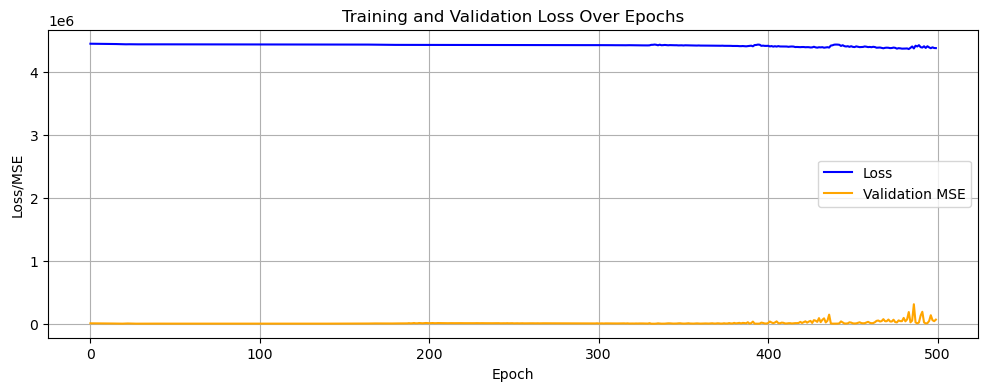

In [15]:
import pandas as pd
import torch
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader  # 用于批处理的DataLoader

# deal_data_encoded.csv已经包含之前的one-hot编码和其他特征
deal_data_encoded = pd.read_csv('data_del_en.csv')

# 根据 'InRoom' 标签进行排序
deal_data_encoded = deal_data_encoded.sort_values(by='InRoom')

# 确保 'InRoom' 列为 datetime 类型
deal_data_encoded['InRoom'] = pd.to_datetime(deal_data_encoded['InRoom'], errors='coerce')

# 求手术次数和平均操作时长的数据范围
op_data = deal_data_encoded[deal_data_encoded['InRoom'].dt.month.isin([1, 2, 3, 4, 5, 6])]

# 计算每位医生的手术次数
doctor_surgery_count_by_type = op_data.groupby(['工号']).size().reset_index(name='手术次数')
# 计算每位医生执行手术的平均操作时长
doctor_avg_duration_by_type = op_data.groupby(['工号'])['操作时长'].mean().reset_index(name='平均操作时长')

# 将手术次数和平均操作时长合并到原始数据中
deal_data_encoded = pd.merge(deal_data_encoded, doctor_surgery_count_by_type, on='工号', how='left')
deal_data_encoded = pd.merge(deal_data_encoded, doctor_avg_duration_by_type, on='工号', how='left')

# 更新手术次数和平均操作时长后，重新根据 'InRoom' 标签划分训练集、验证集和测试集
train_data = deal_data_encoded[deal_data_encoded['InRoom'].dt.month.isin([1, 2, 3, 4, 5, 6])]
valid_data = deal_data_encoded[deal_data_encoded['InRoom'].dt.month == 7]  # 7月作为验证集
test_data = deal_data_encoded[deal_data_encoded['InRoom'].dt.month == 8]  # 8月作为测试集

# 数值特征列
train_numerical_features = train_data[['年龄_数值', '性别编码', '手术等级']].values
valid_numerical_features = valid_data[['年龄_数值', '性别编码', '手术等级']].values
test_numerical_features = test_data[['年龄_数值', '性别编码', '手术等级']].values

# 将这些数值特征转换为 PyTorch 张量
train_numerical_features_tensor = torch.tensor(train_numerical_features, dtype=torch.float)
valid_numerical_features_tensor = torch.tensor(valid_numerical_features, dtype=torch.float)
test_numerical_features_tensor = torch.tensor(test_numerical_features, dtype=torch.float)

print("训练数值特征张量形状: ", train_numerical_features_tensor.shape)
print("验证数值特征张量形状: ", valid_numerical_features_tensor.shape)
print("测试数值特征张量形状: ", test_numerical_features_tensor.shape)

# 合并数值特征与 one-hot 编码特征

#'工号_', '类目_', '亚目_', '细目_', '操作_'
train_one_hot_features = train_data.filter(regex='^(工号_|类目_|亚目_|细目_|操作_)').values
valid_one_hot_features = valid_data.filter(regex='^(工号_|类目_|亚目_|细目_|操作_)').values
test_one_hot_features = test_data.filter(regex='^(工号_|类目_|亚目_|细目_|操作_)').values
# 将这些 one-hot 特征转换为 PyTorch 张量
train_one_hot_features_tensor = torch.tensor(train_one_hot_features, dtype=torch.float)
valid_one_hot_features_tensor = torch.tensor(valid_one_hot_features, dtype=torch.float)
test_one_hot_features_tensor = torch.tensor(test_one_hot_features, dtype=torch.float)
# 将数值特征与one-hot编码特征按列拼接
train_combined_features_tensor = torch.cat([train_one_hot_features_tensor, train_numerical_features_tensor], dim=1)
valid_combined_features_tensor = torch.cat([valid_one_hot_features_tensor, valid_numerical_features_tensor], dim=1)
test_combined_features_tensor = torch.cat([test_one_hot_features_tensor, test_numerical_features_tensor], dim=1)
print("合并后的训练特征张量形状: ", train_combined_features_tensor.shape)
print("合并后的验证特征张量形状: ", valid_combined_features_tensor.shape)
print("合并后的测试特征张量形状: ", test_combined_features_tensor.shape)

# 添加手术编号
train_data['手术编号'] = range(len(train_data))
valid_data['手术编号'] = range(len(valid_data))
test_data['手术编号'] = range(len(test_data))

# 确保 '工号' 和 '手术编号' 列存在，再生成 edge_index
train_doctor_ids = train_data['工号'].astype('category').cat.codes.values
train_surgery_ids = train_data['手术编号'].values

valid_doctor_ids = valid_data['工号'].astype('category').cat.codes.values
valid_surgery_ids = valid_data['手术编号'].values

test_doctor_ids = test_data['工号'].astype('category').cat.codes.values
test_surgery_ids = test_data['手术编号'].values

# 创建边索引
train_edge_index = torch.tensor([train_doctor_ids, train_surgery_ids], dtype=torch.long)
valid_edge_index = torch.tensor([valid_doctor_ids, valid_surgery_ids], dtype=torch.long)
test_edge_index = torch.tensor([test_doctor_ids, test_surgery_ids], dtype=torch.long)

# 构建 HeteroData 数据并添加边
train_data_hg = HeteroData()
train_data_hg['doctor', 'performs', 'surgery'].edge_index = train_edge_index

valid_data_hg = HeteroData()
valid_data_hg['doctor', 'performs', 'surgery'].edge_index = valid_edge_index

test_data_hg = HeteroData()
test_data_hg['doctor', 'performs', 'surgery'].edge_index = test_edge_index

# 将 One-Hot 编码的布尔型特征转换为整型（0/1）
train_doctor_features = train_doctor_features.astype(int)
valid_doctor_features = valid_doctor_features.astype(int)
test_doctor_features = test_doctor_features.astype(int)

# 将手术次数和平均操作时长添加到医生特征中
train_doctor_features = pd.concat([train_doctor_features, train_data[['手术次数', '平均操作时长']].fillna(0)], axis=1)
valid_doctor_features = pd.concat([valid_doctor_features, valid_data[['手术次数', '平均操作时长']].fillna(0)], axis=1)
test_doctor_features = pd.concat([test_doctor_features, test_data[['手术次数', '平均操作时长']].fillna(0)], axis=1)
# 确保所有列为数值型
train_doctor_features = train_doctor_features.apply(pd.to_numeric, errors='coerce').fillna(0)
valid_doctor_features = valid_doctor_features.apply(pd.to_numeric, errors='coerce').fillna(0)
test_doctor_features = test_doctor_features.apply(pd.to_numeric, errors='coerce').fillna(0)

# 术式相关的基本特征列
surgery_basic_features = ['年龄_数值', '性别编码', '手术等级']

# 从每个数据集中选取术式相关特征
train_surgery_features = pd.concat([train_data[surgery_basic_features], train_data.filter(regex='^(类目_|亚目_|细目_|操作_)')], axis=1)
valid_surgery_features = pd.concat([valid_data[surgery_basic_features], valid_data.filter(regex='^(类目_|亚目_|细目_|操作_)')], axis=1)
test_surgery_features = pd.concat([test_data[surgery_basic_features], test_data.filter(regex='^(类目_|亚目_|细目_|操作_)')], axis=1)

# 确保所有列为数值型，如果有非数值列则移除或转换
train_surgery_features = train_surgery_features.apply(pd.to_numeric, errors='coerce').fillna(0)
valid_surgery_features = valid_surgery_features.apply(pd.to_numeric, errors='coerce').fillna(0)
test_surgery_features = test_surgery_features.apply(pd.to_numeric, errors='coerce').fillna(0)

# 再次检查非数值列，移除包含非数值数据的列
train_surgery_features = train_surgery_features.select_dtypes(include=[np.number])
valid_surgery_features = valid_surgery_features.select_dtypes(include=[np.number])
test_surgery_features = test_surgery_features.select_dtypes(include=[np.number])

# 创建 HeteroData 对象
train_data_hg['doctor'].x = torch.tensor(train_doctor_features.values, dtype=torch.float)
valid_data_hg['doctor'].x = torch.tensor(valid_doctor_features.values, dtype=torch.float)
test_data_hg['doctor'].x = torch.tensor(test_doctor_features.values, dtype=torch.float)
# 添加手术节点
train_data_hg['surgery'].x = torch.tensor(train_surgery_features.values, dtype=torch.float)
valid_data_hg['surgery'].x = torch.tensor(valid_surgery_features.values, dtype=torch.float)
test_data_hg['surgery'].x = torch.tensor(test_surgery_features.values, dtype=torch.float)

# 定义隐层和输出层的维度
hidden_channels = 64  # 隐层特征数，可调节
target_channels = 2  # 输出特征数，通常设为目标标签的维度

class GNNModel(torch.nn.Module): 
    def __init__(self, doctor_feature_dim, surgery_feature_dim, hidden_channels, target_channels):
        super(GNNModel, self).__init__()
        self.conv1 = SAGEConv(doctor_feature_dim, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels * 2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.linear = torch.nn.Linear(surgery_feature_dim, hidden_channels)

        # 添加第二轮的医生特征卷积
        self.conv4 = SAGEConv(hidden_channels * 2, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        self.conv6 = SAGEConv(hidden_channels, target_channels)

        # 修改MLP层为3层
        self.mlp1 = torch.nn.Linear(hidden_channels + target_channels, hidden_channels)
        self.mlp2 = torch.nn.Linear(hidden_channels, hidden_channels)  # 新增层
        self.mlp3 = torch.nn.Linear(hidden_channels, target_channels)  # 输出层

    def forward(self, data):
        doctor_x = data['doctor'].x
        surgery_x = data['surgery'].x

        # 第一轮
        x = self.conv1(doctor_x, data['doctor', 'performs', 'surgery'].edge_index).relu()
        surgery_x_transformed = self.linear(surgery_x)

        x = torch.cat([x, surgery_x_transformed], dim=1)
         
        x = self.conv2(x, data['doctor', 'performs', 'surgery'].edge_index).relu()
        x = self.conv3(x, data['doctor', 'performs', 'surgery'].edge_index).relu()

        # 在 conv3 和 conv4 之间再连接
        x = torch.cat([x, surgery_x_transformed], dim=1)  # 确保 x 的维度为 (N, hidden_channels + hidden_channels)

        # 第二轮处理
        x = self.conv4(x, data['doctor', 'performs', 'surgery'].edge_index).relu()
        x = self.conv5(x, data['doctor', 'performs', 'surgery'].edge_index).relu()
        x = self.conv6(x, data['doctor', 'performs', 'surgery'].edge_index)

        # MLP层
        x = torch.cat([x, surgery_x_transformed], dim=1)
        x = self.mlp1(x).relu()
        x = self.mlp2(x).relu()  # 新增的ReLU激活
        x = self.mlp3(x)  # 输出层
        return x


# 实例化模型
doctor_features_shape = train_doctor_features.shape[1]  # 医生特征维度
surgery_features_shape = train_surgery_features.shape[1]  # 手术特征维度
model = GNNModel(doctor_features_shape, surgery_features_shape, hidden_channels, target_channels)

learning_rate = 1e-3
num_epochs = 500
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()  # 均方误差损失函数
'''
学习率调度器
'''
lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=200,
        gamma=0.9,
        last_epoch=-1
)

# 假设操作时长和台次时长在原始数据中
train_target = torch.tensor(train_data[['操作时长', '台次时长']].values, dtype=torch.float)
valid_target = torch.tensor(valid_data[['操作时长', '台次时长']].values, dtype=torch.float)
test_target = torch.tensor(test_data[['操作时长', '台次时长']].values, dtype=torch.float)

# 将训练数据装入 DataLoader
batch_size = 32  # 根据可用内存调整
train_data_loader = DataLoader([train_data_hg], batch_size=batch_size, shuffle=True)  # 用训练集创建 DataLoader

# 存储指标
losses = []
maes = []
mses = []
valid_mses = []
valid_maes = []

# 训练过程
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_data in train_data_loader:
        optimizer.zero_grad()

        out = model(batch_data[0])
        
        # 更新目标标签的索引
        target_indices = train_target[:out.size(0)]
        
        loss = criterion(out, target_indices)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # 更新学习率
    lr_scheduler.step()  

    # 计算 MAE 和 MSE
    with torch.no_grad():
        mse = torch.mean((out - train_target[:out.size(0)]) ** 2)
        mae = torch.mean(torch.abs(out - train_target[:out.size(0)]))

    # 存储损失和指标
    losses.append(epoch_loss / len(train_data_loader))
    mses.append(mse.item())
    maes.append(mae.item())

    # 验证集评估
    model.eval()
    with torch.no_grad():
        valid_out = model(valid_data_hg)
        valid_mse = torch.mean((valid_out - valid_target) ** 2)
        valid_mae = torch.mean(torch.abs(valid_out - valid_target))
        valid_mses.append(valid_mse.item())
        valid_maes.append(valid_mae.item())

    print(f'Epoch {epoch}: Loss: {epoch_loss / len(train_data_loader)}, MSE: {mse.item()}, MAE: {mae.item()}, Valid MSE: {valid_mse.item()}, Valid MAE: {valid_mae.item()}')

# 训练结束后评估测试集
model.eval()
with torch.no_grad():
    test_out = model(test_data_hg)
    test_mse = torch.mean((test_out - test_target) ** 2)
    test_mae = torch.mean(torch.abs(test_out - test_target))

print(f'Test MSE: {test_mse.item()}, Test MAE: {test_mae.item()}')

# 绘制 Loss 图
plt.figure(figsize=(12, 4))
plt.plot(losses, label='Loss', color='blue')
plt.plot(valid_mses, label='Validation MSE', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss/MSE')
plt.legend()
plt.grid()
plt.show()